In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['OPENBLAS_NUM_THREAD'] = '1'

In [16]:
device = 'cuda'

In [25]:
%run training.ipynb

In [18]:
import gc
import itertools
import math
import typing as ty
from copy import deepcopy
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.swa_utils as swa_utils
import zero
from torch import Tensor

import node


# %%
class NODE(nn.Module):
    def __init__(
        self,
        *,
        d_in: int,
        num_layers: int,
        layer_dim: int,
        depth: int,
        tree_dim: int,
        choice_function: str,
        bin_function: str,
        d_out: int,
        categories: ty.Optional[ty.List[int]],
        d_embedding: int,
    ) -> None:
        super().__init__()

        if categories is not None:
            d_in += len(categories) * d_embedding
            category_offsets = torch.tensor([0] + categories[:-1]).cumsum(0)
            self.register_buffer('category_offsets', category_offsets)
            self.category_embeddings = nn.Embedding(sum(categories), d_embedding)
            nn.init.kaiming_uniform_(self.category_embeddings.weight, a=math.sqrt(5))
            print(f'{self.category_embeddings.weight.shape=}')

        self.d_out = d_out
        self.block = node.DenseBlock(
            input_dim=d_in,
            num_layers=num_layers,
            layer_dim=layer_dim,
            depth=depth,
            tree_dim=tree_dim,
            bin_function=getattr(node, bin_function),
            choice_function=getattr(node, choice_function),
            flatten_output=False,
        )

    def forward(self, x_num: Tensor, x_cat: Tensor) -> Tensor:
        if x_cat is not None:
            x_cat = self.category_embeddings(x_cat + self.category_offsets[None])
            x = torch.cat([x_num, x_cat.view(x_cat.size(0), -1)], dim=-1)
        else:
            x = x_num

        x = self.block(x)
        x = x[..., : self.d_out].mean(dim=-2)
        x = x.squeeze(-1)
        return x

In [24]:
train_params = {
    'batch_size' : 256,
    'eval_batch_size' : 1024,
    'num_epochs' : 300,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_in' : 27,
    'd_out' : 100,
    'categories' : None,
    'd_embedding' : None,
    "bin_function": "entmoid15",
    "choice_function": "entmax15",
    "depth": 6,
    "layer_dim": 1024,
    "num_layers": 1,
    "tree_dim": 100
}

optimizer_params = {
    'lr' : 0.001,
    'weight_decay' : 0.0
}

catboost_params = {
    'bagging_temperature' : 0.6788373487088936,
    'depth' : 5,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 3.066893023126909,
    'leaf_estimation_iterations' : 10,
    'learning_rate' : 0.04324396670696182,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

In [29]:
dataset_folder = 'helena'
metric = accuracy_score

#data_model, data_cb = DataLoadAndScale(dataset_folder)
#results_models_learning = LearnNModels(6, NODE, model_params, optimizer_params, data_model, train_params, metric, file_to_load='node.pt')
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=3, ensemble_size=3, ensemble_N=2)

0:	learn: 0.1719154	test: 0.1664110	best: 0.1664110 (0)	total: 146ms	remaining: 4m 52s
10:	learn: 0.2085850	test: 0.2016871	best: 0.2017830 (7)	total: 1.65s	remaining: 4m 59s
20:	learn: 0.2452545	test: 0.2358129	best: 0.2358129 (20)	total: 4.42s	remaining: 6m 56s
30:	learn: 0.2609529	test: 0.2488497	best: 0.2488497 (30)	total: 7.28s	remaining: 7m 42s
40:	learn: 0.2727447	test: 0.2618865	best: 0.2618865 (40)	total: 10.2s	remaining: 8m 9s
50:	learn: 0.2842249	test: 0.2707055	best: 0.2707055 (50)	total: 13.3s	remaining: 8m 26s
60:	learn: 0.2952737	test: 0.2781825	best: 0.2781825 (60)	total: 16.3s	remaining: 8m 39s
70:	learn: 0.3039018	test: 0.2829755	best: 0.2829755 (70)	total: 19.4s	remaining: 8m 47s
80:	learn: 0.3126019	test: 0.2926572	best: 0.2926572 (80)	total: 22.5s	remaining: 8m 54s
90:	learn: 0.3221647	test: 0.2996549	best: 0.2996549 (90)	total: 25.6s	remaining: 8m 57s
100:	learn: 0.3297383	test: 0.3031058	best: 0.3031058 (100)	total: 28.8s	remaining: 9m
110:	learn: 0.3369763	test:

  0%|                                                     | 0/3 [00:00<?, ?it/s]

0:	learn: 0.3103250	test: 0.3196894	best: 0.3196894 (0)	total: 105ms	remaining: 3m 30s
10:	learn: 0.4176014	test: 0.4224502	best: 0.4224502 (10)	total: 1.57s	remaining: 4m 43s
20:	learn: 0.4675726	test: 0.4769939	best: 0.4769939 (20)	total: 3.9s	remaining: 6m 7s
30:	learn: 0.5101620	test: 0.5181173	best: 0.5181173 (30)	total: 6.74s	remaining: 7m 8s
40:	learn: 0.5585754	test: 0.5610621	best: 0.5610621 (40)	total: 9.63s	remaining: 7m 40s
50:	learn: 0.5903077	test: 0.5923121	best: 0.5923121 (50)	total: 12.7s	remaining: 8m 3s
60:	learn: 0.6193558	test: 0.6185775	best: 0.6185775 (60)	total: 15.7s	remaining: 8m 19s
70:	learn: 0.6452641	test: 0.6413919	best: 0.6413919 (70)	total: 18.7s	remaining: 8m 28s
80:	learn: 0.6674336	test: 0.6591258	best: 0.6591258 (80)	total: 21.7s	remaining: 8m 34s
90:	learn: 0.6857684	test: 0.6773390	best: 0.6773390 (90)	total: 24.8s	remaining: 8m 39s
100:	learn: 0.7019941	test: 0.6887462	best: 0.6887462 (100)	total: 27.8s	remaining: 8m 42s
110:	learn: 0.7168057	tes

 33%|██████████████▋                             | 1/3 [10:01<20:03, 601.52s/it]

0:	learn: 0.3075928	test: 0.3155675	best: 0.3155675 (0)	total: 103ms	remaining: 3m 25s
10:	learn: 0.4319816	test: 0.4375959	best: 0.4375959 (10)	total: 1.25s	remaining: 3m 46s
20:	learn: 0.4654396	test: 0.4766104	best: 0.4766104 (20)	total: 3.45s	remaining: 5m 25s
30:	learn: 0.5105455	test: 0.5179256	best: 0.5179256 (30)	total: 6.3s	remaining: 6m 40s
40:	learn: 0.5560109	test: 0.5560775	best: 0.5560775 (40)	total: 9.22s	remaining: 7m 20s
50:	learn: 0.5907391	test: 0.5900115	best: 0.5900115 (50)	total: 12.2s	remaining: 7m 46s
60:	learn: 0.6179896	test: 0.6169479	best: 0.6169479 (60)	total: 15.2s	remaining: 8m 3s
70:	learn: 0.6440658	test: 0.6442676	best: 0.6442676 (70)	total: 18.2s	remaining: 8m 15s
80:	learn: 0.6658518	test: 0.6623850	best: 0.6623850 (80)	total: 21.2s	remaining: 8m 22s
90:	learn: 0.6849056	test: 0.6782017	best: 0.6782017 (90)	total: 24.2s	remaining: 8m 28s
100:	learn: 0.7004122	test: 0.6923888	best: 0.6923888 (100)	total: 27.3s	remaining: 8m 32s
110:	learn: 0.7161825	t

 67%|█████████████████████████████▎              | 2/3 [19:53<09:55, 595.68s/it]

0:	learn: 0.3073291	test: 0.3125959	best: 0.3125959 (0)	total: 111ms	remaining: 3m 41s
10:	learn: 0.4376138	test: 0.4455521	best: 0.4455521 (10)	total: 1.3s	remaining: 3m 54s
20:	learn: 0.4709280	test: 0.4789110	best: 0.4789110 (20)	total: 4.12s	remaining: 6m 28s
30:	learn: 0.5144281	test: 0.5185966	best: 0.5185966 (30)	total: 7.1s	remaining: 7m 31s
40:	learn: 0.5581919	test: 0.5598160	best: 0.5598160 (40)	total: 10.1s	remaining: 8m 4s
50:	learn: 0.5928722	test: 0.5929831	best: 0.5929831 (50)	total: 13.2s	remaining: 8m 25s
60:	learn: 0.6211773	test: 0.6232745	best: 0.6232745 (60)	total: 16.4s	remaining: 8m 40s
70:	learn: 0.6464625	test: 0.6454179	best: 0.6454179 (70)	total: 19.5s	remaining: 8m 48s
80:	learn: 0.6676733	test: 0.6630560	best: 0.6630560 (80)	total: 22.6s	remaining: 8m 55s
90:	learn: 0.6863436	test: 0.6763804	best: 0.6763804 (90)	total: 25.7s	remaining: 8m 59s
100:	learn: 0.7034321	test: 0.6884586	best: 0.6884586 (100)	total: 28.8s	remaining: 9m 1s
110:	learn: 0.7179321	tes

100%|████████████████████████████████████████████| 3/3 [30:07<00:00, 602.43s/it]


0:	learn: 0.3076647	test: 0.3138420	best: 0.3138420 (0)	total: 104ms	remaining: 3m 27s
10:	learn: 0.3906864	test: 0.3994440	best: 0.3994440 (10)	total: 1.12s	remaining: 3m 22s
20:	learn: 0.4606222	test: 0.4678873	best: 0.4678873 (20)	total: 3.24s	remaining: 5m 4s
30:	learn: 0.4994248	test: 0.5030675	best: 0.5030675 (30)	total: 6.19s	remaining: 6m 33s
40:	learn: 0.5438117	test: 0.5440951	best: 0.5440951 (40)	total: 9.24s	remaining: 7m 21s
50:	learn: 0.5801937	test: 0.5807132	best: 0.5807132 (50)	total: 12.3s	remaining: 7m 48s
60:	learn: 0.6100566	test: 0.6107170	best: 0.6107170 (60)	total: 15.4s	remaining: 8m 8s
70:	learn: 0.6364203	test: 0.6365031	best: 0.6365031 (70)	total: 18.4s	remaining: 8m 20s
80:	learn: 0.6584939	test: 0.6559624	best: 0.6559624 (80)	total: 21.5s	remaining: 8m 29s
90:	learn: 0.6780031	test: 0.6718750	best: 0.6718750 (90)	total: 24.6s	remaining: 8m 35s
100:	learn: 0.6968172	test: 0.6863497	best: 0.6863497 (100)	total: 27.6s	remaining: 8m 38s
110:	learn: 0.7128991	t

In [30]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.3585122699386503
distill_0 : 0.3821319018404908 ---------> 0.3562883435582822
model_1_metric : 0.356058282208589
distill_1 : 0.3821319018404908 ---------> 0.35460122699386504
model_2_metric : 0.3575153374233129
distill_2 : 0.3821319018404908 ---------> 0.35460122699386504
averaged ensembles accuracy :  0.3552147239263803


In [31]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 1024,
    'num_epochs' : 60,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_in' : 54,
    'd_out' : 4,
    'categories' : None,
    'd_embedding' : None,
    "bin_function": "entmoid15",
    "choice_function": "entmax15",
    "depth": 6,
    "layer_dim": 1024,
    "num_layers": 2,
    "tree_dim": 4
}

optimizer_params = {
    'lr' : 0.001,
    'weight_decay' : 0.0
}

catboost_params = {
    'bagging_temperature' : 0.1775789113135668,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 8.333715101902845,
    'leaf_estimation_iterations' : 3,
    'learning_rate' : 0.04816591530865447,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 1,
    'eval_metric': 'Accuracy'
}

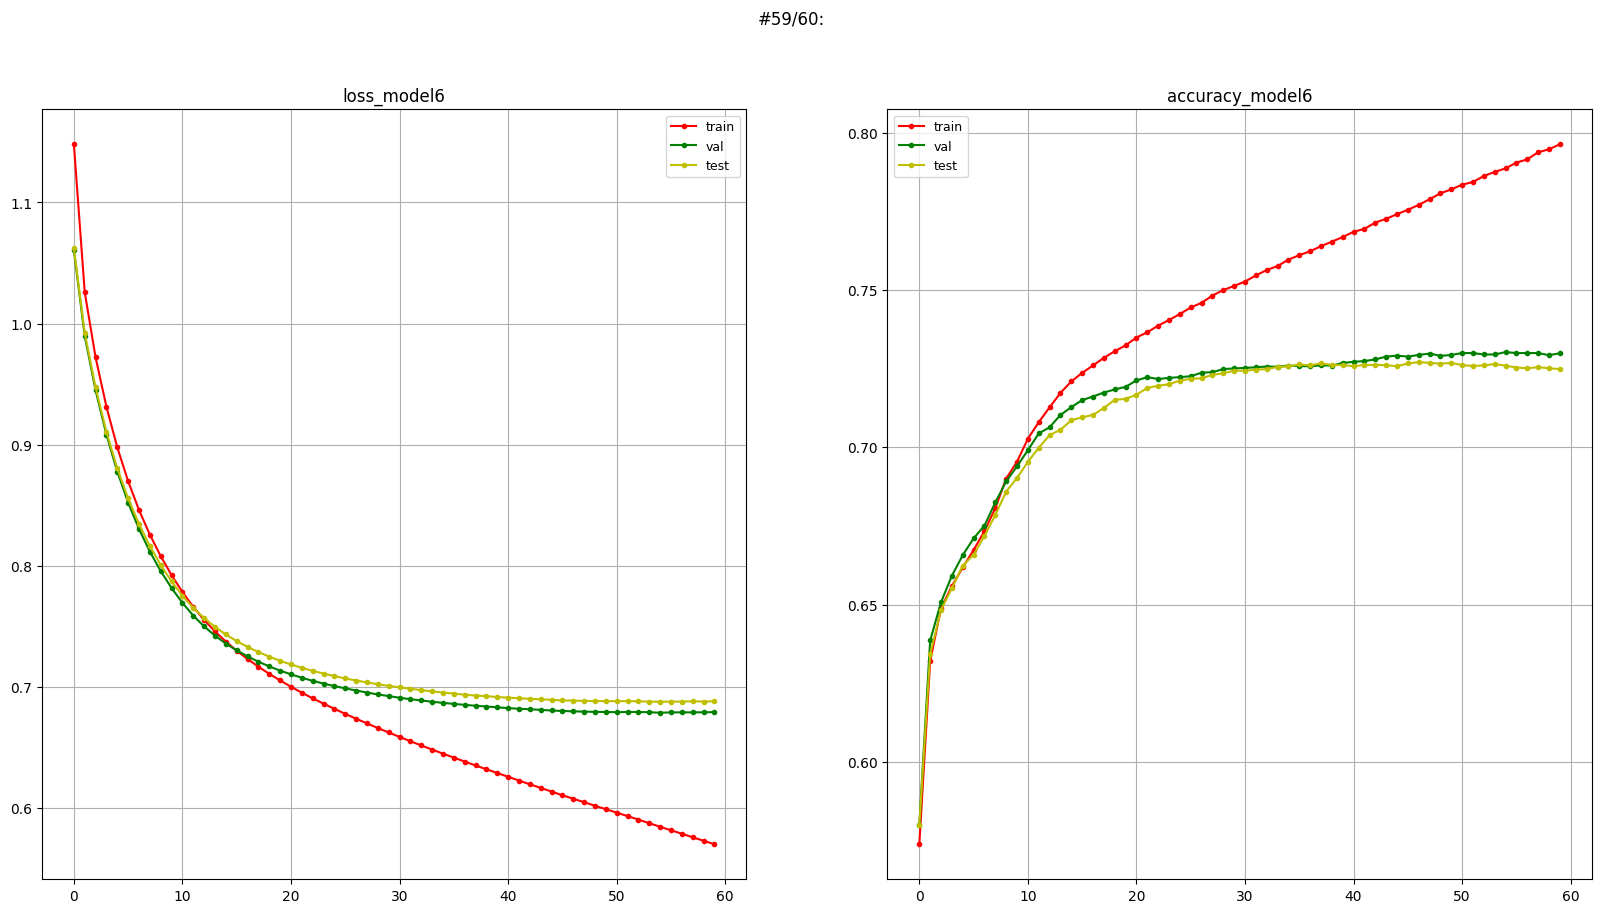

100%|███████████████████████████████████████████| 60/60 [24:57<00:00, 24.95s/it]


0:	learn: 0.6486527	test: 0.6512166	best: 0.6512166 (0)	total: 37.6ms	remaining: 1m 15s
10:	learn: 0.6818504	test: 0.6703986	best: 0.6703986 (10)	total: 410ms	remaining: 1m 14s
20:	learn: 0.6928230	test: 0.6785341	best: 0.6791312 (19)	total: 783ms	remaining: 1m 13s
30:	learn: 0.7022468	test: 0.6848037	best: 0.6848037 (30)	total: 1.17s	remaining: 1m 14s
40:	learn: 0.7106815	test: 0.6921182	best: 0.6921182 (40)	total: 1.55s	remaining: 1m 14s
50:	learn: 0.7180899	test: 0.6965965	best: 0.6965965 (50)	total: 1.91s	remaining: 1m 12s
60:	learn: 0.7238374	test: 0.7012987	best: 0.7012987 (60)	total: 2.26s	remaining: 1m 11s
70:	learn: 0.7283347	test: 0.7059263	best: 0.7059263 (70)	total: 2.6s	remaining: 1m 10s
80:	learn: 0.7329813	test: 0.7080908	best: 0.7080908 (79)	total: 2.94s	remaining: 1m 9s
90:	learn: 0.7373666	test: 0.7093596	best: 0.7103299 (89)	total: 3.28s	remaining: 1m 8s
100:	learn: 0.7416772	test: 0.7113748	best: 0.7114495 (98)	total: 3.63s	remaining: 1m 8s
110:	learn: 0.7455027	tes

  0%|                                                     | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7518848	test: 0.7520525	best: 0.7520525 (0)	total: 32.4ms	remaining: 1m 4s
10:	learn: 0.8011495	test: 0.7996716	best: 0.7996716 (10)	total: 350ms	remaining: 1m 3s
20:	learn: 0.8168620	test: 0.8125093	best: 0.8125093 (20)	total: 662ms	remaining: 1m 2s
30:	learn: 0.8287303	test: 0.8219137	best: 0.8219137 (30)	total: 973ms	remaining: 1m 1s
40:	learn: 0.8392737	test: 0.8314674	best: 0.8314674 (40)	total: 1.28s	remaining: 1m 1s
50:	learn: 0.8486042	test: 0.8391551	best: 0.8391551 (50)	total: 1.59s	remaining: 1m
60:	learn: 0.8574494	test: 0.8458725	best: 0.8458725 (60)	total: 1.89s	remaining: 59.9s
70:	learn: 0.8636635	test: 0.8510225	best: 0.8510225 (70)	total: 2.18s	remaining: 59.2s
80:	learn: 0.8702508	test: 0.8562472	best: 0.8562472 (80)	total: 2.48s	remaining: 58.7s
90:	learn: 0.8761663	test: 0.8594566	best: 0.8594566 (90)	total: 2.78s	remaining: 58.4s
100:	learn: 0.8802904	test: 0.8628900	best: 0.8628900 (100)	total: 3.08s	remaining: 58s
110:	learn: 0.8846384	test: 0.866920

 33%|███████████████                              | 1/3 [01:02<02:05, 62.98s/it]

0:	learn: 0.7582295	test: 0.7589192	best: 0.7589192 (0)	total: 34.9ms	remaining: 1m 9s
10:	learn: 0.8138389	test: 0.8084789	best: 0.8084789 (10)	total: 355ms	remaining: 1m 4s
20:	learn: 0.8296820	test: 0.8229587	best: 0.8229587 (20)	total: 667ms	remaining: 1m 2s
30:	learn: 0.8419795	test: 0.8346768	best: 0.8346768 (30)	total: 981ms	remaining: 1m 2s
40:	learn: 0.8528402	test: 0.8448276	best: 0.8448276 (40)	total: 1.29s	remaining: 1m 1s
50:	learn: 0.8627118	test: 0.8525899	best: 0.8525899 (50)	total: 1.6s	remaining: 1m 1s
60:	learn: 0.8706987	test: 0.8591581	best: 0.8591581 (60)	total: 1.9s	remaining: 1m
70:	learn: 0.8776032	test: 0.8640096	best: 0.8640096 (70)	total: 2.2s	remaining: 59.9s
80:	learn: 0.8843398	test: 0.8667712	best: 0.8668458 (78)	total: 2.5s	remaining: 59.2s
90:	learn: 0.8899380	test: 0.8713987	best: 0.8713987 (90)	total: 2.79s	remaining: 58.6s
100:	learn: 0.8940434	test: 0.8737125	best: 0.8740110 (99)	total: 3.09s	remaining: 58.1s
110:	learn: 0.8982795	test: 0.8774444	b

 67%|██████████████████████████████               | 2/3 [02:05<01:02, 62.96s/it]

0:	learn: 0.7554117	test: 0.7586207	best: 0.7586207 (0)	total: 33.2ms	remaining: 1m 6s
10:	learn: 0.8053296	test: 0.8020600	best: 0.8020600 (10)	total: 361ms	remaining: 1m 5s
20:	learn: 0.8209301	test: 0.8148231	best: 0.8148231 (20)	total: 687ms	remaining: 1m 4s
30:	learn: 0.8330970	test: 0.8258695	best: 0.8258695 (30)	total: 1s	remaining: 1m 3s
40:	learn: 0.8443681	test: 0.8351993	best: 0.8351993 (40)	total: 1.32s	remaining: 1m 2s
50:	learn: 0.8540531	test: 0.8427377	best: 0.8427377 (50)	total: 1.62s	remaining: 1m 1s
60:	learn: 0.8620773	test: 0.8507240	best: 0.8507240 (60)	total: 1.91s	remaining: 1m
70:	learn: 0.8686833	test: 0.8567697	best: 0.8567697 (70)	total: 2.21s	remaining: 60s
80:	learn: 0.8746921	test: 0.8618451	best: 0.8619197 (79)	total: 2.5s	remaining: 59.3s
90:	learn: 0.8803837	test: 0.8646067	best: 0.8654277 (88)	total: 2.79s	remaining: 58.6s
100:	learn: 0.8854408	test: 0.8688610	best: 0.8688610 (100)	total: 3.09s	remaining: 58.2s
110:	learn: 0.8899380	test: 0.8716973	be

100%|█████████████████████████████████████████████| 3/3 [03:09<00:00, 63.05s/it]


0:	learn: 0.7582854	test: 0.7603374	best: 0.7603374 (0)	total: 32.2ms	remaining: 1m 4s
10:	learn: 0.8094349	test: 0.8077325	best: 0.8077325 (10)	total: 345ms	remaining: 1m 2s
20:	learn: 0.8236172	test: 0.8189282	best: 0.8189282 (20)	total: 660ms	remaining: 1m 2s
30:	learn: 0.8355789	test: 0.8290790	best: 0.8290790 (30)	total: 965ms	remaining: 1m 1s
40:	learn: 0.8468500	test: 0.8381848	best: 0.8381848 (40)	total: 1.27s	remaining: 1m
50:	learn: 0.8570762	test: 0.8460964	best: 0.8460964 (50)	total: 1.57s	remaining: 60s
60:	learn: 0.8659401	test: 0.8546052	best: 0.8546052 (60)	total: 1.87s	remaining: 59.4s
70:	learn: 0.8723408	test: 0.8593820	best: 0.8593820 (70)	total: 2.17s	remaining: 58.9s
80:	learn: 0.8784429	test: 0.8647559	best: 0.8647559 (80)	total: 2.46s	remaining: 58.2s
90:	learn: 0.8838173	test: 0.8687117	best: 0.8687864 (88)	total: 2.75s	remaining: 57.8s
100:	learn: 0.8882586	test: 0.8721451	best: 0.8721451 (100)	total: 3.05s	remaining: 57.3s
110:	learn: 0.8927558	test: 0.874906

In [32]:
dataset_folder = 'jannis'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile')
results_models_learning = LearnNModels(6, NODE, model_params, optimizer_params, data_model, train_params, metric, file_to_load='node.pt')
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=3, ensemble_size=3, ensemble_N=2)

In [33]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.7275930017316534
distill_0 : 0.724547680181525 ---------> 0.7243685436197528
model_1_metric : 0.7239505583089508
distill_1 : 0.724547680181525 ---------> 0.7239505583089508
model_2_metric : 0.7229951633128322
distill_2 : 0.724547680181525 ---------> 0.7248462411178122
averaged ensembles accuracy :  0.7232638681554906


In [54]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 2048,
    'num_epochs' : 65,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_in' : 28,
    'd_out' : 2,
    'categories' : None,
    'd_embedding' : None,
    "bin_function": "entmoid15",
    "choice_function": "entmax15",
    "depth": 6,
    "layer_dim": 1024,
    "num_layers": 2,
    "tree_dim": 3
}

optimizer_params = {
    'lr' : 0.001,
    'weight_decay' : 0.0
}

catboost_params = {
    'bagging_temperature' : 0.2762051354652655,
    'depth' : 9,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 5.6958564294846,
    'leaf_estimation_iterations' : 8,
    'learning_rate' : 0.04558033669158746,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

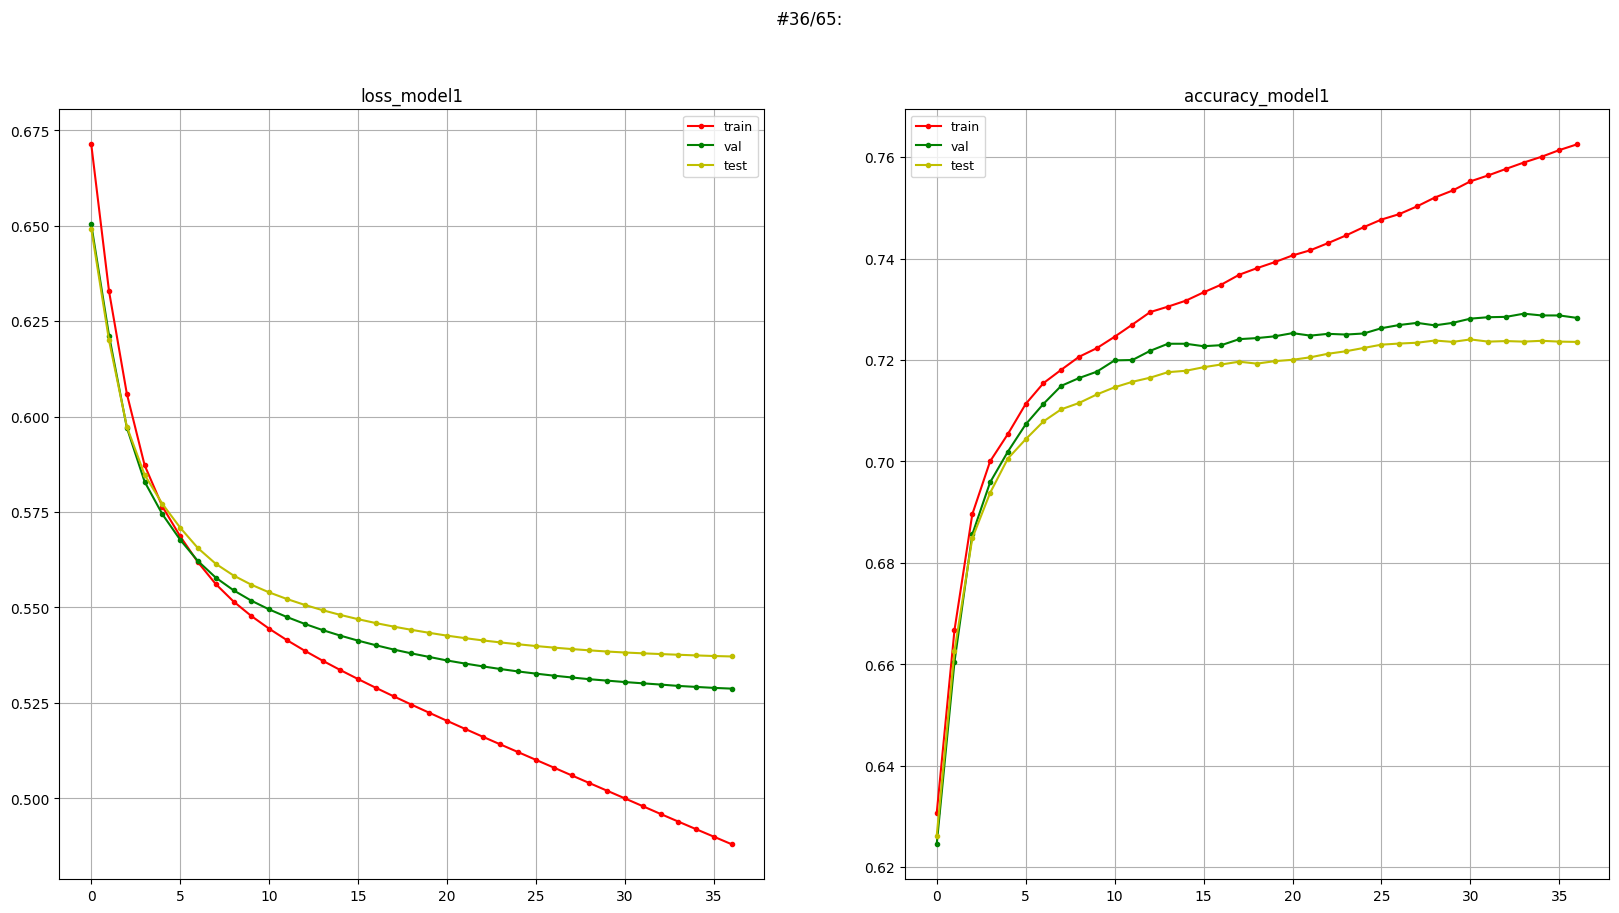

 57%|████████████████████████▍                  | 37/65 [15:32<11:40, 25.00s/it]

In [ ]:
dataset_folder = 'higgs_small'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile')
results_models_learning = LearnNModels(9, NODE, model_params, optimizer_params, data_model, train_params, metric, file_to_load='node.pt')
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=3, ensemble_size=3, ensemble_N=3)

In [ ]:
PrintResults(results_models_learning, results_cb_learning)

In [ ]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 2048,
    'num_epochs' : 350,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

model_params = {
    'd_in' : 8,
    'd_out' : 1,
    'categories' : None,
    'd_embedding' : None,
    "bin_function": "entmoid15",
    "choice_function": "entmax15",
    "depth": 6,
    "layer_dim": 1024,
    "num_layers": 1,
    "tree_dim": 2
}

optimizer_params = {
    'lr' : 0.001,
    'weight_decay' : 0.0
}

catboost_params = {
    'bagging_temperature' : 0.004350736313860622,
    'depth' : 9,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 8.157639995907031,
    'leaf_estimation_iterations' : 4,
    'learning_rate' : 0.1021076879315874,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}

In [ ]:
dataset_folder = 'california_housing'
metric = mean_squared_error

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile', regression=True)
results_models_learning = LearnNModels(9, NODE, model_params, optimizer_params, data_model, train_params, metric, file_to_load='node.pt', regression=True)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostRegressor, catboost_params, data_cb, metric, N=5, ensemble_size=3, regression=True, ensemble_N=3)

In [ ]:
PrintResults(results_models_learning, results_cb_learning, regression=True, std=data_cb['std'])

In [52]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 1024,
    'num_epochs' : 400,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

model_params = {
    'd_in' : 90,
    'd_out' : 1,
    'categories' : None,
    'd_embedding' : None,
    "bin_function": "entmoid15",
    "choice_function": "entmax15",
    "depth": 6,
    "layer_dim": 1024,
    "num_layers": 2,
    "tree_dim": 3
}

optimizer_params = {
    'lr' : 0.001,
    'weight_decay' : 0.0
}

catboost_params = {
    'bagging_temperature' : 0.8324949854063162,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 1.077941041711693,
    'leaf_estimation_iterations' : 2,
    'learning_rate' : 0.04659912850277395,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}

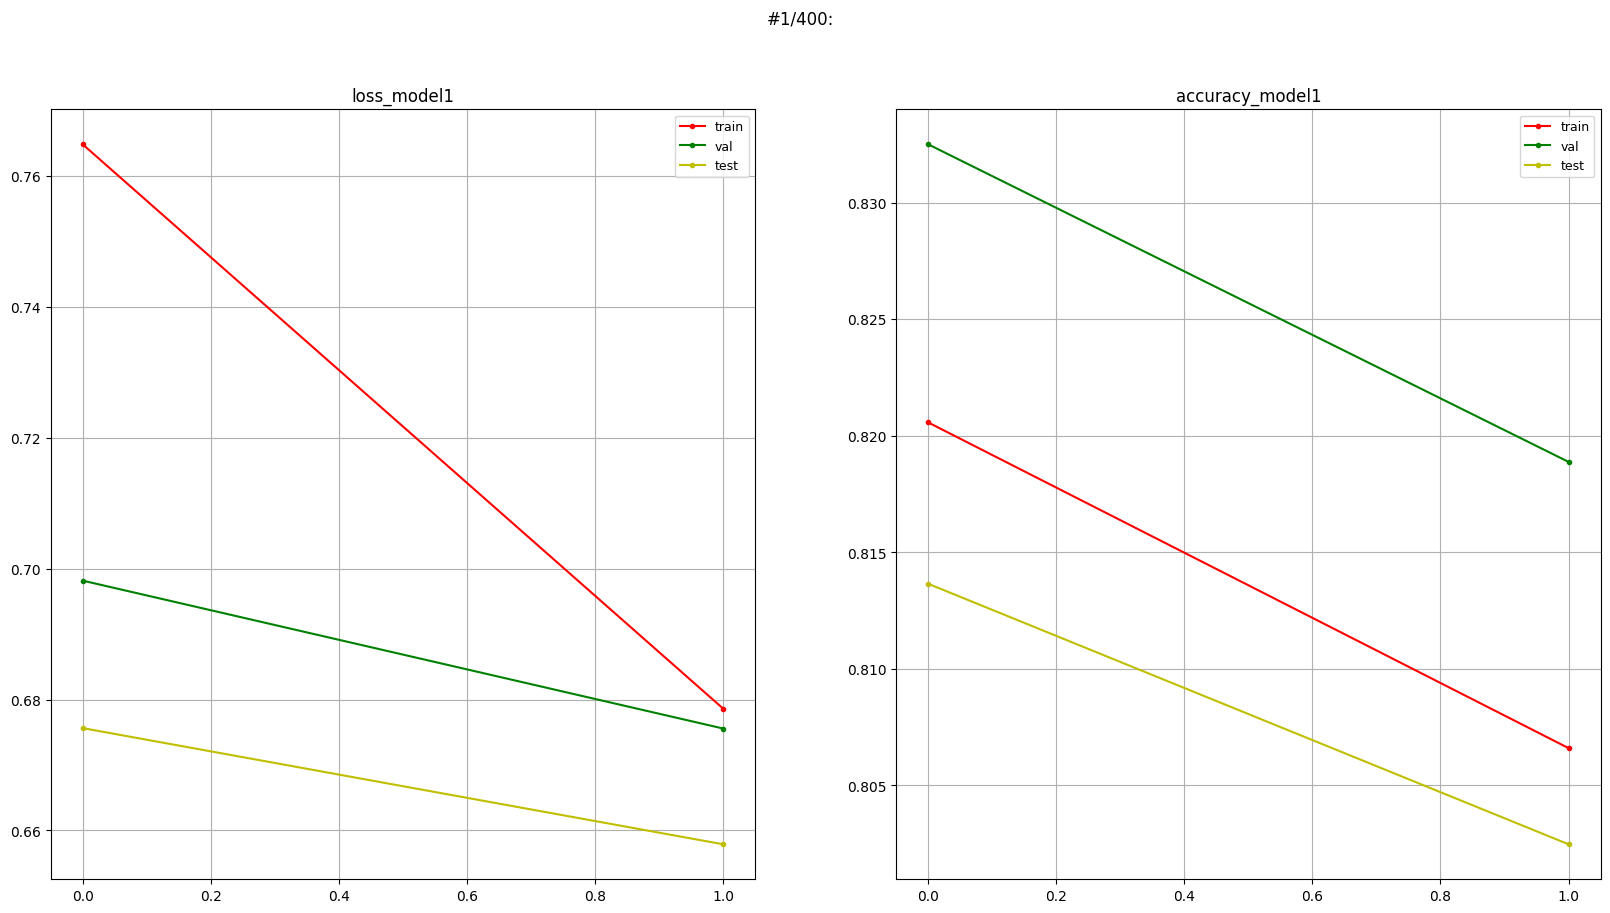

  0%|▏                                      | 2/400 [07:07<23:39:18, 213.97s/it]


KeyboardInterrupt: 

In [53]:
dataset_folder = 'year'
metric = mean_squared_error

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile', regression=True)
results_models_learning = LearnNModels(6, NODE, model_params, optimizer_params, data_model, train_params,
                                       metric, file_to_load='node.pt', regression=True)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostRegressor, catboost_params, data_cb, metric, N=3, ensemble_size=3, regression=True, ensemble_N=2)

In [ ]:
PrintResults(results_models_learning, results_cb_learning, regression=True, std=data_cb['std'])

In [51]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 1024,
    'num_epochs' : 400,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

model_params = {
    'd_in' : 90,
    'd_out' : 1,
    'categories' : None,
    'd_embedding' : None,
    "bin_function": "entmoid15",
    "choice_function": "entmax15",
    "depth": 6,
    "layer_dim": 1024,
    "num_layers": 2,
    "tree_dim": 3
}

optimizer_params = {
    'lr' : 0.001,
    'weight_decay' : 0.0
}

catboost_params = {
    'bagging_temperature' : 0.8324949854063162,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 1.077941041711693,
    'leaf_estimation_iterations' : 2,
    'learning_rate' : 0.04659912850277395,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}